# 

In [1]:
# ========================== Libraries ===========================
# essentials
import sys, os, time
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# data format related
import csv
from netCDF4 import Dataset as NetCDFFile

# statistics
import scipy.linalg as la
from scipy.interpolate import griddata
from scipy import stats
import scipy.interpolate as scinterp
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss

# ploting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import ticker, cm
from matplotlib.offsetbox import AnchoredText 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy as cart 
import imageio



In [2]:
# ========================== Function definitions ===========================
def map_plot(data, lon, lat, proj, subplot_num, cmap, data_label, vmin, vmax, units, subtitle):
    '''
    Plot a netcdf output as a map
    Arguments :
    data : variable to plot, proj : projection, subplot_num : 121 (for example),
    lon, lat : lontitude and latitude arrays associated to the data
    cmap : colormap's name (str), title: figure's title (str)
    data_label : variable's name (str), vmin and vmax, units = units (str)
    '''
    # -------- Cartopy and co --------
    ax = fig.add_subplot(subplot_num, projection = proj)
    ax.set_global()
    ax.set_extent([lonmin, lonmax, latmin, latmax+2], crs=ccrs.PlateCarree())
    ax.add_feature(cart.feature.LAND, alpha = 0.4, facecolor=("tan"))
    ax.add_feature(cart.feature.OCEAN, alpha = 0, facecolor=("cornflowerblue"))
    if circular == True:
            ax.set_boundary(circle, transform=ax.transAxes)     # circular shape
    # ------------- plot -------------
    nc_map = ax.pcolormesh(lon, lat, data, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.9, transform = data_crs)
    #nc_map = ax.contourf(wrf_lon_corner, wrf_lat_corner, data, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.9, transform = data_crs)
    # --------- plot params ----------
    ax.coastlines('50m')
    ax.set_xlabel('Longitude (°O)')
    ax.set_ylabel('Latitude (°N)')
    cbar = fig.colorbar(nc_map, shrink = 0.7, pad = 0.08, extend = 'max') 
    cbar.set_label(data_label + units, fontsize = 20) 
    cbar.ax.tick_params(labelsize=18)
    ax.set_title(subtitle, fontsize = 16)
    # ----------- Gridlines ----------
    gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=0.5, color="black", y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))
    gls.ylabel_style = {'color': 'black', 'weight': 'normal'}
    ax.set_frame_on(True)
    
def savefig(path, name, dpi):
    '''
    Function that saves a figure to path_and_name.
    path : path to which the figure must be saved (string)
    name : the name of the figure.
    '''
    fig.tight_layout(pad=2.5)
    path_and_name = path + name
    print('Saving of {}'.format(path_and_name))
    try:
        os.mkdir(path)
    except FileExistsError: 
            pass
    plt.savefig(path_and_name, dpi = dpi)
    return



In [13]:
# ============== Open and read netCDF files ===============
datadir = '/home/jovyan/prepared-data/ERA5'
filename = '/2018/merged/cloudIce_201808.nc'

data_xr = xr.open_mfdataset(datadir + filename, engine = 'netcdf4')
data_xr.cbh

<xarray.DataArray 'cbh' (valid_time: 31, latitude: 241, longitude: 1440)> Size: 43MB
dask.array<open_dataset-cbh, shape=(31, 241, 1440), dtype=float32, chunksize=(16, 121, 720), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * valid_time  (valid_time) datetime64[ns] 248B 2018-08-01 ... 2018-08-31
    number      int64 8B ...
Attributes: (12/32)
    GRIB_paramId:                             228023
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      347040
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Cloud base height
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [5]:
# ================ Map plotting ==================
# ____________________________ PARAMETERS ______________________________
# ------------ Region selection -----------
latmax, latmin = 90, 30
lonmax, lonmin = 180, -180
central_lon = 0
# ------------- Projections ---------------
polar_proj = ccrs.NorthPolarStereo(true_scale_latitude=75, central_longitude = central_lon)
ortho_zoom_proj = ccrs.Orthographic(central_longitude = central_lon, central_latitude = (latmax+latmin)/2)
cartesian_proj = ccrs.Mercator(central_longitude = 0, min_latitude=latmin, max_latitude=latmax)
platecarree= ccrs.PlateCarree(central_longitude = (lonmax+lonmin)/2)
data_crs = ccrs.PlateCarree()
# _______ param selection ______
proj = ortho_zoom_proj         # projection selection
dpi = 150                      # pixel density of plots
circular = False               # for circular frame
# _____________________________#
# ------------ Circular frame ------------
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ----------------------------------------
# ______________________________________________________________________

In [75]:
data_xr.var

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 254MB
Dimensions:     (valid_time: 61, latitude: 241, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 2kB 90.0 89.75 89.5 89.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * valid_time  (valid_time) datetime64[ns] 488B 2018-08-01 ... 2018-09-30
    number      int64 8B 0
Data variables:
    strd        (valid_time, latitude, longitude) float32 85MB dask.array<chunksize=(16, 121, 720), meta=np.ndarray>
    cbh         (valid_time, latitude, longitude) float32 85MB dask.array<chunksize=(16, 121, 720), meta=np.ndarray>
    tciw        (valid_time, latitude, longitude) float32 85MB dask.array<chunksize=(16, 121, 720), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Eu

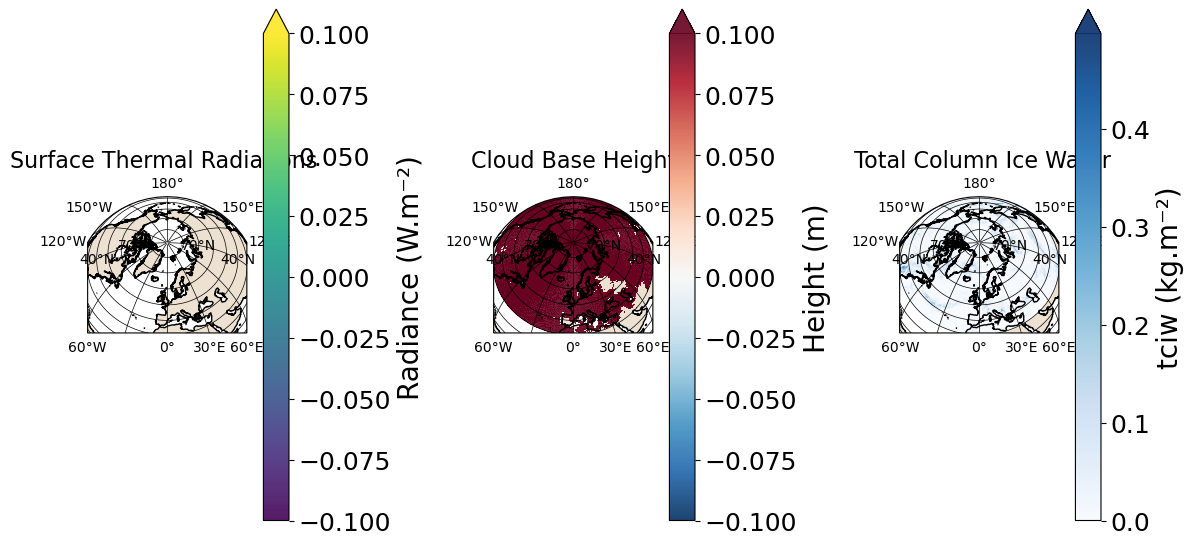

In [11]:
fig = plt.figure(figsize =(12,8))
# Variable 1
# ---------- Data settings ------------
data = data_xr.strd[0].to_numpy()
lon = data_xr.longitude
lat = data_xr.latitude
vmin, vmax = np.min(data), np.max(data)
cmap = 'viridis'
dataname = 'Radiance'
units = ' (W.m⁻²)'
subtitle = 'Surface Thermal Radiations '
# ------------- Plotting -----------------
map_plot(data, lon, lat, proj, 131, cmap, dataname, vmin ,vmax, units, subtitle)
# Variable 2
# ---------- Data settings ------------
data = data_xr.cbh[0].to_numpy()
lon = data_xr.longitude
lat = data_xr.latitude
vmin, vmax = np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = 'Height'
units = ' (m)'
subtitle = 'Cloud Base Height'
# ------------- Plotting -----------------
map_plot(data, lon, lat, proj, 132, cmap, dataname, vmin ,vmax, units, subtitle)
# Variable 3
# ---------- Data settings ------------
data = data_xr.tciw[0].to_numpy()
lon = data_xr.longitude
lat = data_xr.latitude
vmin, vmax = np.min(data), np.max(data)
cmap = 'Blues'
dataname = 'tciw'
units = ' (kg.m⁻²)'
subtitle = ' Total Column Ice Water'
# ------------- Plotting -----------------
map_plot(data, lon, lat, proj, 133, cmap, dataname, vmin ,vmax, units, subtitle)

fig.tight_layout(pad=2.5)

In [13]:
# ========= Create a concatenated dataset ==========
data_allvar = xr.concat([data_xr[var] for var in data_xr.data_vars], dim="valid_time")
# translate into numpy array
data_allvar = data_allvar.to_numpy()

In [104]:
# ========== Variable preprocess ==========
sdata = data_xr.strd.to_numpy()
sdata_mean = np.mean(sdata, axis = 0)
sdata_anom = sdata - sdata_mean
sdata_anom.shape

(61, 241, 1440)

In [106]:
# ========== Weighting by the latitude ==========
def weigh_by_coslat(data, lat):
    '''
    Data weighting by the cosine of the latitude. 
    data : data to weigh as numpy array
    lat : array of latitude
    '''
    # Compute the weights: square root of the cosine of the latitude
    weights = np.sqrt(np.cos(np.radians(lat)))
    # Reshape the weights to match the data shape
    if data.ndim == 3:
        weights_reshaped = weights[np.newaxis, :, np.newaxis]  # (time, lat, lon)
    elif data.ndim == 2:
        weights_reshaped = weights[:, np.newaxis]  # (lat, lon)
    # Weigh the data
    data_weighted = data * weights_reshaped
    return data_weighted

In [107]:
def PCA_EOF(data_weighted, data, lat, lon):
    '''
    PCA with weighted data.
    data_weighted : the weighted data
    data : the studied data as numpy array
    lat, lon : longitude and latitude arrays
    '''
    # Flatten the lat and lon dimension
    data_weighted_2d = np.reshape(data_weighted, (data_weighted.shape[0], data_weighted.shape[1]*data_weighted.shape[2]))
    data_2d =  np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    # Compute the covariance matrix
    data_cov = np.cov(data_weighted_2d)
    # filter infinity and NaN values
    data_cov[np.where(np.isinf(data_cov))] = 0
    data_cov[np.where(np.isnan(data_cov) == True)] = 0
    # Compute the eigen values and vectors
    (eigvals,eigvect) = la.eig(data_cov)
    vp1 = (eigvals[0]/eigvals.sum()).real
    vp2 = (eigvals[1]/eigvals.sum()).real
    vp3 = (eigvals[2]/eigvals.sum()).real
    vp1_5 = (np.sum(eigvals[0:5]/eigvals.sum())).real              
    print('Fraction of explained variance :\n- mode 1 : {}%\n- mode 2 : {}%\n- 5 first modes : {}%'.format(round(vp1*100,1), round(vp2*100, 1), round(vp1_5*100, 1)))
    n_time = data_2d.shape[0]
    n_lat = len(lat)
    n_lon = len(lon)
    # ------- First components and EOFs -------
    pc1 = (eigvect[:,0]-eigvect[:,0].mean())/eigvect[:,0].std()
    pc2 = (eigvect[:,1]-eigvect[:,1].mean())/eigvect[:,1].std()
    pc3 = (eigvect[:,2]-eigvect[:,2].mean())/eigvect[:,2].std()
    eof1 = np.reshape(pc1 @ data_2d / n_time,(n_lat,n_lon))
    eof2 = np.reshape(pc2 @ data_2d / n_time,(n_lat,n_lon))
    eof3 = np.reshape(pc3 @ data_2d / n_time,(n_lat,n_lon))
    eof1[np.where(np.round(eof1,4) == 0)] = np.nan
    eof2[np.where(np.round(eof2,4) == 0)] = np.nan
    eof3[np.where(np.round(eof3,4) == 0)] = np.nan
    # -------- Figure ---------
    fig = plt.figure(figsize = (8,8))
    gs = GridSpec(10,10)
    fig.suptitle('Spectra of eigen values of the covariance matrix', fontsize = 16)
    # ------------------------------
    ax = fig.add_subplot(gs[:5,:])
    ax.plot(eigvals[0:10].real/eigvals.real.sum(), c = 'darkslategrey')
    ax.scatter(np.arange(0,10), eigvals[0:10].real/eigvals.real.sum(), c = 'teal')
    ax.set_ylabel('Eigen values (normalised)')
    ax.set_xlabel('Eigen vectors')
    ax.grid()
    ax.set_title('mode 1 : {}% \t mode 2 : {}% \t mode 3 : {}%'.format(round(vp1*100,1), round(vp2*100, 1), round(vp3*100,1)))
    # -------------------------------
    ax2 = fig.add_subplot(gs[6:,:])
    ax2.plot(pc1, c = 'teal', label = 'PC1')
    ax2.plot(pc2, c = 'cyan', label = 'PC2')
    ax2.plot(pc3, c = 'blue', label = 'PC3')
    ax2.set_ylabel('')
    ax2.set_xlabel('Time')
    ax2.grid()
    ax2.set_title("Principal components")
    ax2.legend()
    # -----------------------------------------
    return pc1, pc2, pc3, eof1, eof2, eof3


/tmp/ipykernel_1865/1782995782.py:18: RuntimeWarning: invalid value encountered in scalar divide
  vp1 = (eigvals[0]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:19: RuntimeWarning: invalid value encountered in scalar divide
  vp2 = (eigvals[1]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:20: RuntimeWarning: invalid value encountered in scalar divide
  vp3 = (eigvals[2]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:21: RuntimeWarning: invalid value encountered in divide
  vp1_5 = (np.sum(eigvals[0:5]/eigvals.sum())).real


Fraction of explained variance :
- mode 1 : nan%
- mode 2 : nan%
- 5 first modes : nan%


/tmp/ipykernel_1865/1782995782.py:42: RuntimeWarning: invalid value encountered in divide
  ax.plot(eigvals[0:10].real/eigvals.real.sum(), c = 'darkslategrey')
/tmp/ipykernel_1865/1782995782.py:43: RuntimeWarning: invalid value encountered in divide
  ax.scatter(np.arange(0,10), eigvals[0:10].real/eigvals.real.sum(), c = 'teal')


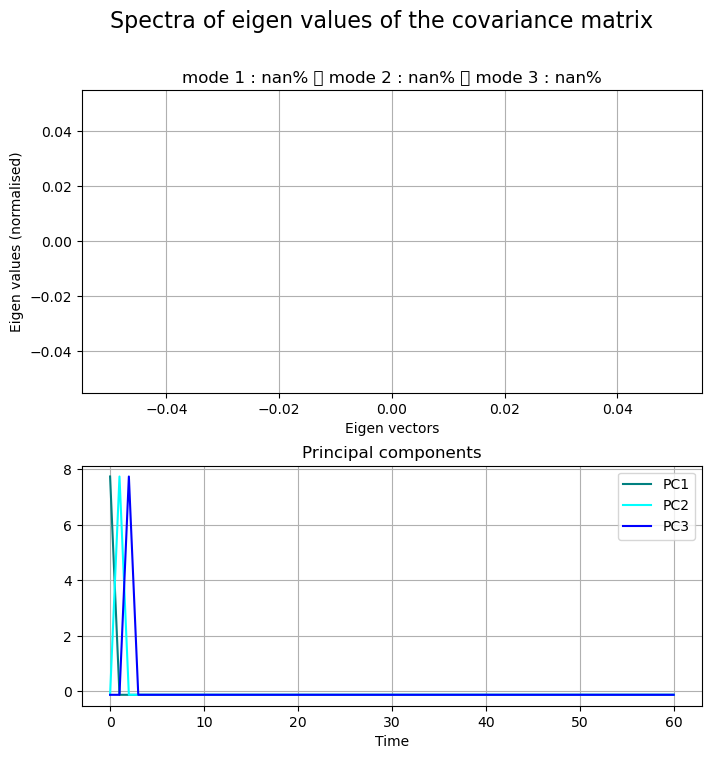

In [100]:
# =========== Execute the analysis ==============
# choose the variable
studied_var = cloudH_anom
# load the latitude and longitude
lat = data_xr.latitude.to_numpy()
lon = data_xr.longitude.to_numpy()
# weigh the data
data_weighted = weigh_by_coslat(studied_var, lat)
# compute the EOF and PCA
pc1, pc2, pc3, eof1, eof2, eof3 = PCA_EOF(data_weighted, studied_var, lat, lon)

In [ ]:
# data visualisation
fig = plt.figure(figsize =(20,7))
# ------------ Variable 1 ------------
# Data settings 
data = surfP_anom
vmin, vmax =  np.min(data), np.max(data)
cmap = 'berlin'
dataname = ''
units = ' (hPa)'
subtitle = 'anomalies'
# Plot
map_plot(data, lon, lat, proj, 131, cmap, dataname, vmin ,vmax, units, subtitle)
# ------------ Variable 2 ------------
# Data settings 
data = np.cov(np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2])))
vmin, vmax =  np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = ''
units = ' '
subtitle = 'Covariance'
# Plotting 
map_plot(data, lon, lat, proj, 132, cmap, dataname, vmin ,vmax, units, subtitle)
# ------------ Variable 3 ------------
# Data settings 
data = e
vmin, vmax =  np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = ''
units = ' '
subtitle = 'EOF 3'
# Plotting 
map_plot(data, lon, lat, proj, 133, cmap, dataname, vmin ,vmax, units, subtitle)
fig.tight_layout(pad=2.5)

/tmp/ipykernel_1865/1782995782.py:18: RuntimeWarning: invalid value encountered in scalar divide
  vp1 = (eigvals[0]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:19: RuntimeWarning: invalid value encountered in scalar divide
  vp2 = (eigvals[1]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:20: RuntimeWarning: invalid value encountered in scalar divide
  vp3 = (eigvals[2]/eigvals.sum()).real
/tmp/ipykernel_1865/1782995782.py:21: RuntimeWarning: invalid value encountered in divide
  vp1_5 = (np.sum(eigvals[0:5]/eigvals.sum())).real


Fraction of explained variance :
- mode 1 : nan%
- mode 2 : nan%
- 5 first modes : nan%


/tmp/ipykernel_1865/1782995782.py:42: RuntimeWarning: invalid value encountered in divide
  ax.plot(eigvals[0:10].real/eigvals.real.sum(), c = 'darkslategrey')
/tmp/ipykernel_1865/1782995782.py:43: RuntimeWarning: invalid value encountered in divide
  ax.scatter(np.arange(0,10), eigvals[0:10].real/eigvals.real.sum(), c = 'teal')


TypeError: Dimensions of C (10, 241, 1440) should be one smaller than X(1440) and Y(241) while using shading='flat' see help(pcolormesh)

/srv/conda/envs/notebook/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


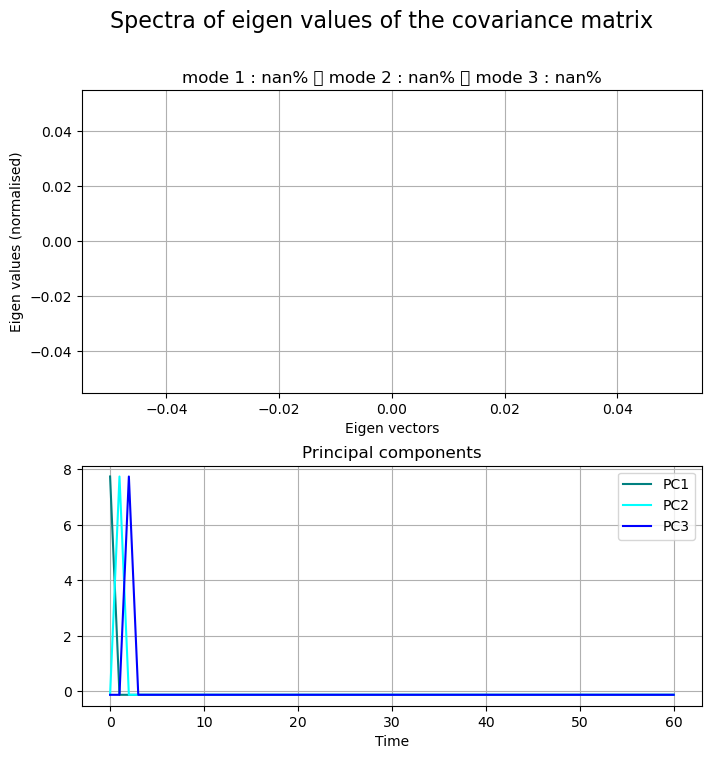

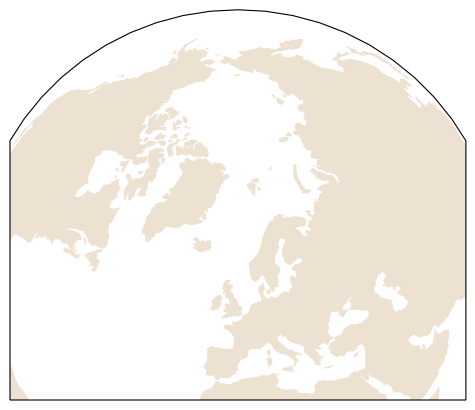

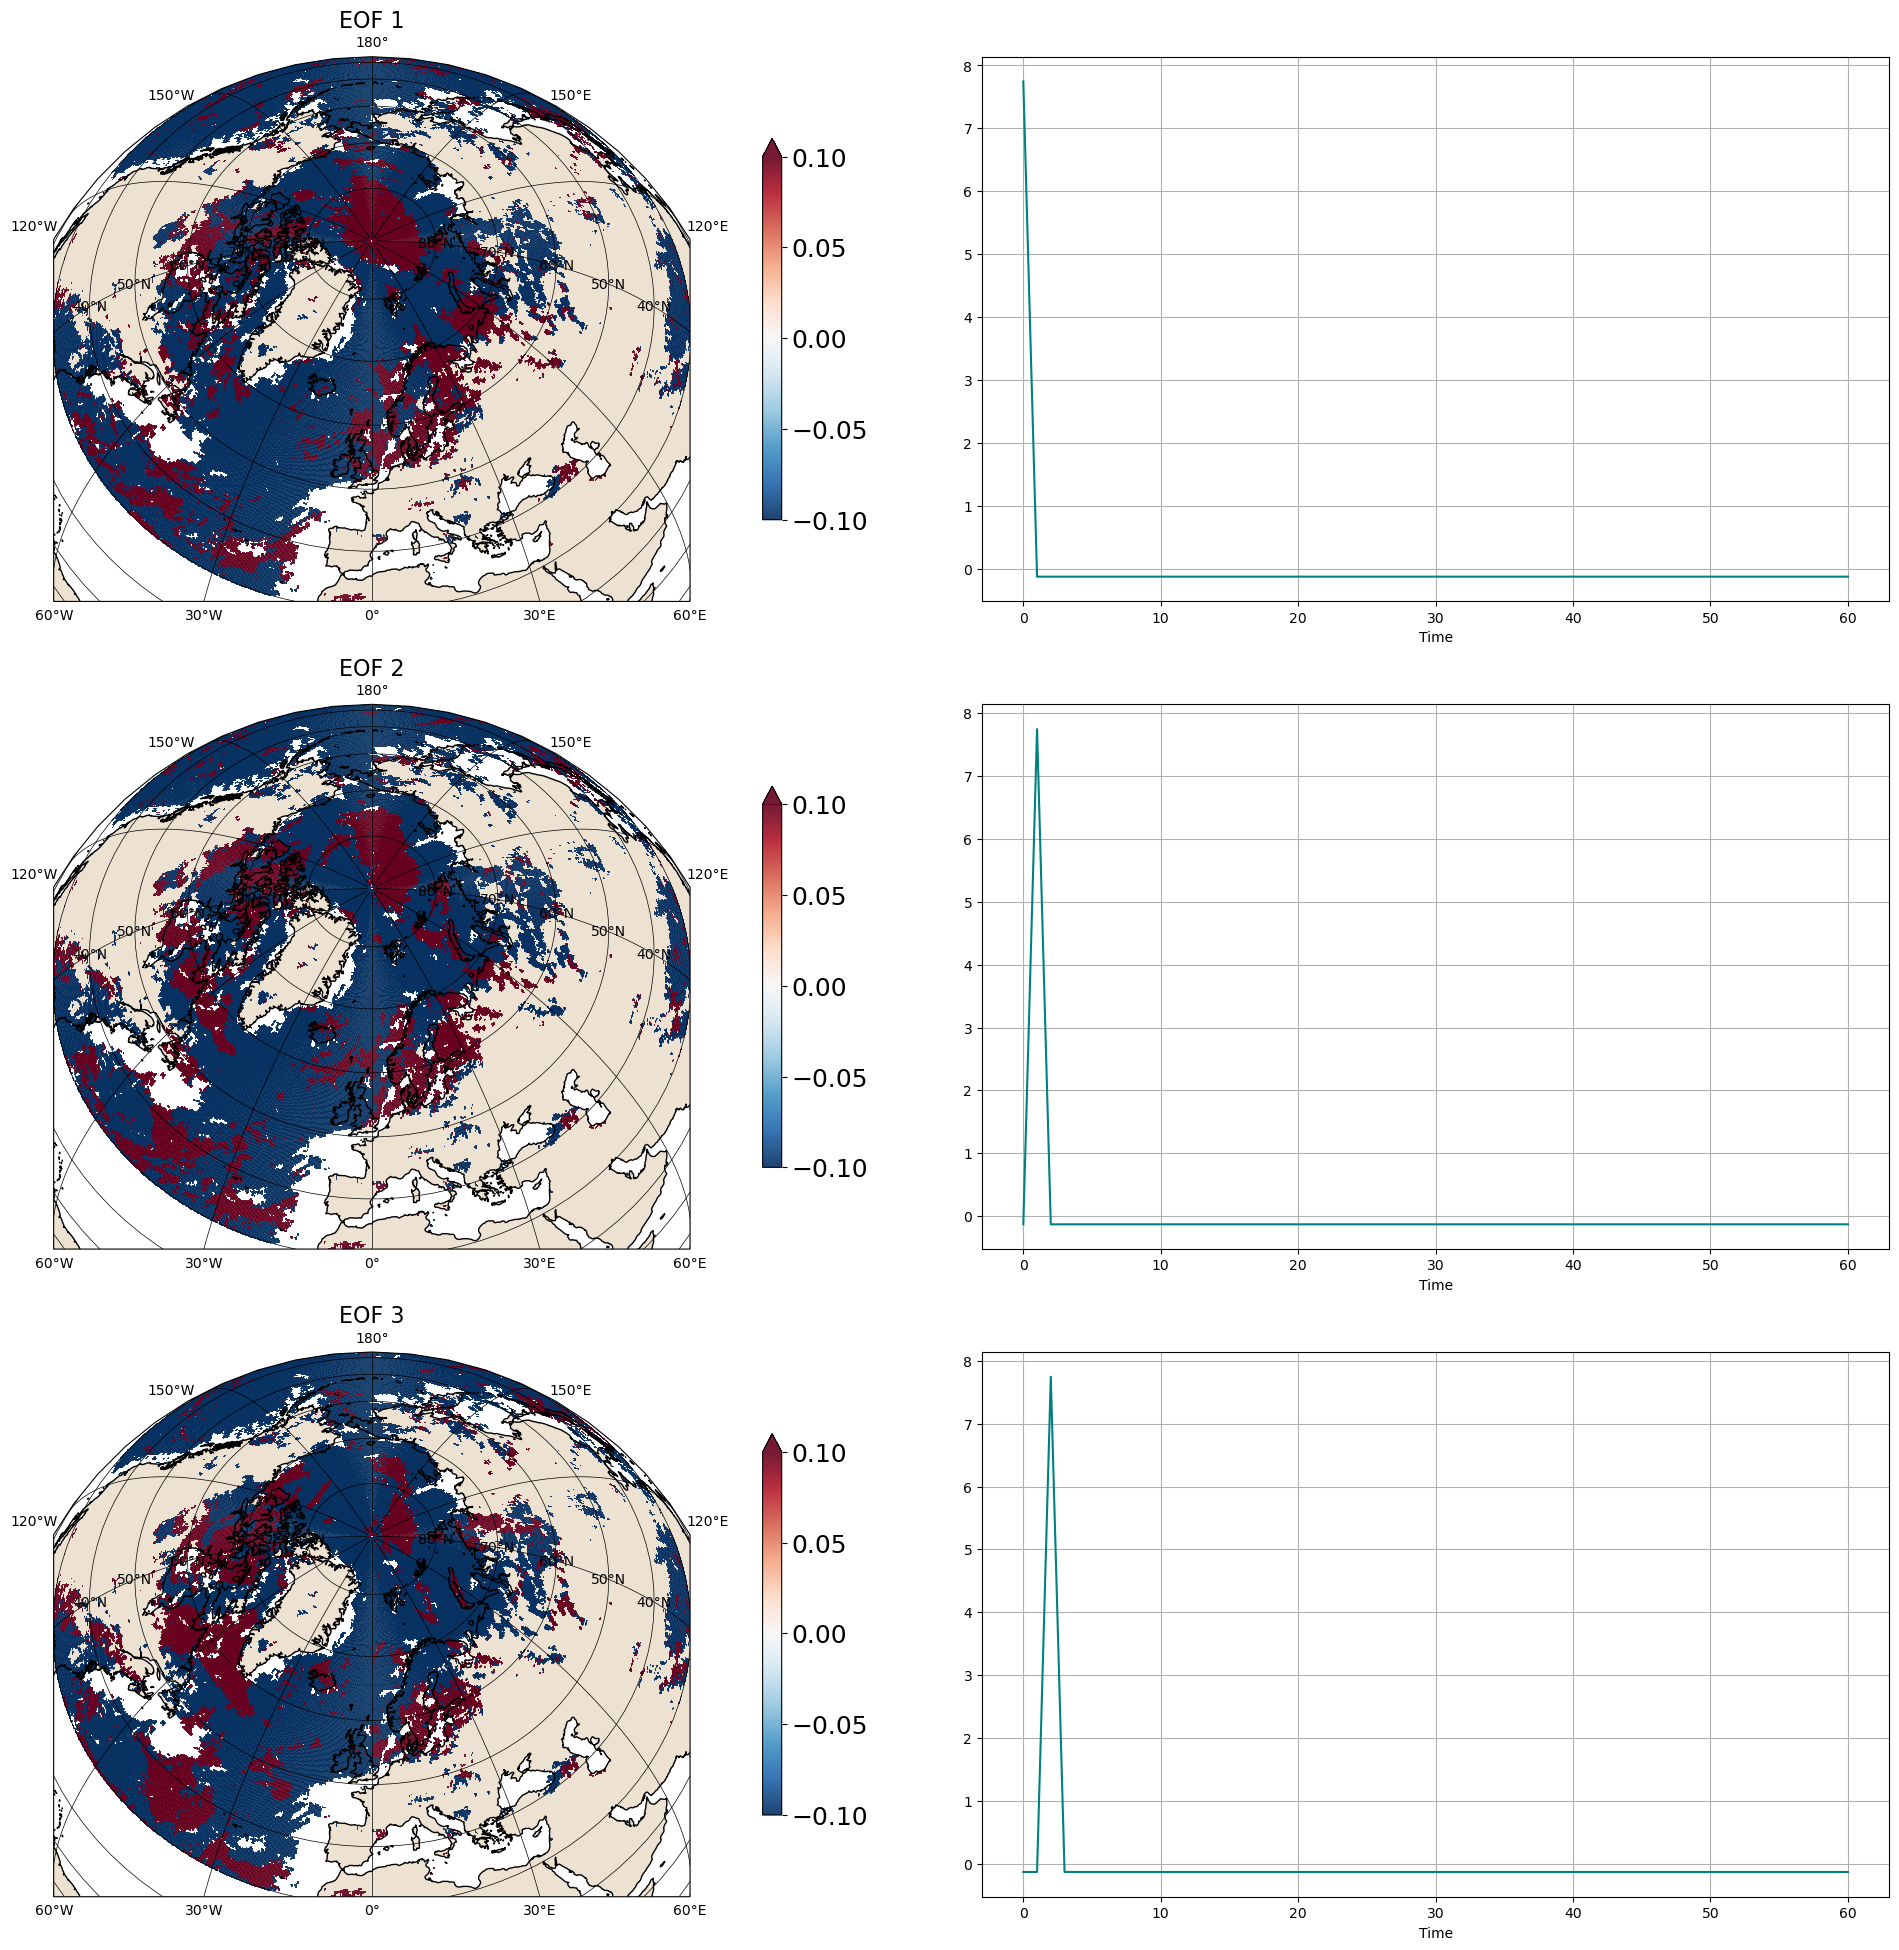

In [108]:
# =========== Plot EOFs and PCs ============
fig = plt.figure(figsize =(20,20))
# ------------ Variable 1 ------------
# Data settings 
data = eof1
vmin, vmax =  np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = ''
units = ' '
subtitle = 'EOF 1'
# Plot
map_plot(data, lon, lat, proj, 321, cmap, dataname, vmin ,vmax, units, subtitle)
# plot the PC
ax = fig.add_subplot(322)
ax.plot(pc1, color = 'teal', label = 'PC1')
ax.grid()
ax.legend
ax.set_xlabel('Time')
# ------------ Variable 2 ------------
# Data settings 
data = eof2
vmin, vmax =  np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = ''
units = ' '
subtitle = 'EOF 2'
# Plotting 
map_plot(data, lon, lat, proj, 323, cmap, dataname, vmin ,vmax, units, subtitle)
# plot the PC
ax = fig.add_subplot(324)
ax.plot(pc2, color = 'teal', label = 'PC2')
ax.grid()
ax.legend
ax.set_xlabel('Time')
# ------------ Variable 3 ------------
# Data settings 
data = eof3
vmin, vmax =  np.min(data), np.max(data)
cmap = 'RdBu_r'
dataname = ''
units = ' '
subtitle = 'EOF 3'
# Plotting 
map_plot(data, lon, lat, proj, 325, cmap, dataname, vmin ,vmax, units, subtitle)
# plot the PC
ax = fig.add_subplot(326)
ax.plot(pc3, color = 'teal', label = 'PC3')
ax.grid()
ax.legend
ax.set_xlabel('Time')

fig.tight_layout(pad=2.5)

In [62]:
# ============ Data reconstruction ===============
data_rec = []
for i in range(0, len(pc1)):
    data_rec.append(eof1*pc1[i])# + eof2*pc2[i])# + eof3*pc3[i])
data_rec = np.asarray(data_rec)     # convert back to numpy array

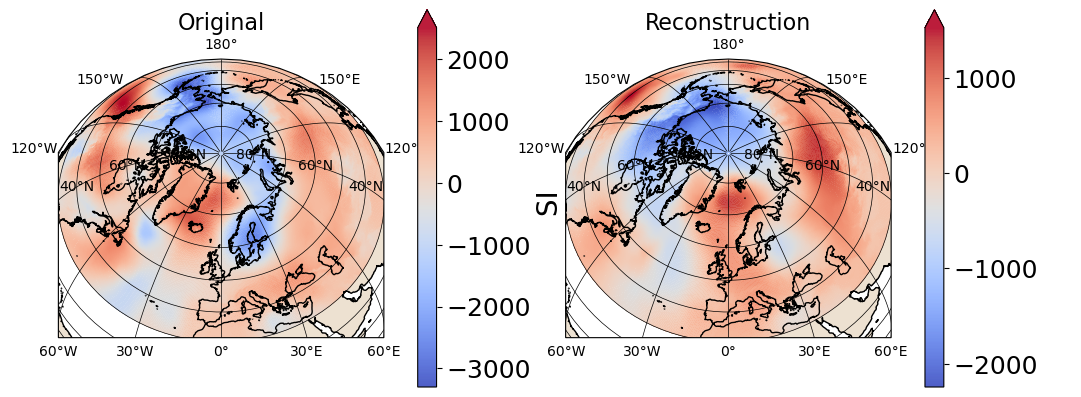

In [63]:
# Plot
fig = plt.figure(figsize =(12,7))
# ------------ Variable 1 ------------
# Data settings 
data = surfP_anom[0]
vmin, vmax =  np.min(data), np.max(data)
cmap = 'coolwarm'
dataname = ''
units = ' SI'
subtitle = 'Original'
# Plot
map_plot(data, lon, lat, proj, 121, cmap, dataname, vmin ,vmax, units, subtitle)
# ------------ Variable 2 ------------
# Data settings 
data = data_rec[0]
vmin, vmax =  np.min(data), np.max(data)
cmap = 'coolwarm'
dataname = ''
units = ' '
subtitle = 'Reconstruction'
# Plotting 
map_plot(data, lon, lat, proj, 122, cmap, dataname, vmin ,vmax, units, subtitle)